## Power Grid Management Project

## Libraries importation

In [ ]:
import numpy as np
import random

## The Micro Grid Class (environement)

In [299]:
class GridEnvironment:
    def __init__(self, num_poles):
        self.num_poles = num_poles
        self.wind_energy_range = (0, 2)
        self.solar_energy_range = (0, 2)
        self.battery_charge_range = (0, 2)
        self.pole_consumption_range = (0, 6)
        self.poles_connected = [False] * num_poles
        self.urban_electricity_usage = 0  # Added variable for urban electricity usage

        self.wind_energy = random.randint(*self.wind_energy_range)
        self.solar_energy = random.randint(*self.solar_energy_range)
        self.battery_charge = random.randint(*self.battery_charge_range)
        self.pole_consumptions = [random.randint(*self.pole_consumption_range) for _ in range(self.num_poles)]
        self.poles_connected = [False] * self.num_poles

    def reset(self):
        self.wind_energy = random.randint(*self.wind_energy_range)
        self.solar_energy = random.randint(*self.solar_energy_range)
        self.battery_charge = random.randint(*self.battery_charge_range)
        self.pole_consumptions = [random.randint(*self.pole_consumption_range) for _ in range(self.num_poles)]
        self.poles_connected = [False] * self.num_poles
        self.urban_electricity_usage = 0  # Reset urban electricity usage
        res = [self.wind_energy, self.solar_energy, self.battery_charge]
        for e in self.pole_consumptions:
            res.append(e)
        return tuple(res)

    def step(self, action): # action = [battery, urban electricity, pole 1, p2, p3, p4]
        # Update the state based on the chosen action
        if action[0] == 0:  # Battery usage: charge
            if self.battery_charge < self.battery_charge_range[1]:
                self.battery_charge += 1
        else :  # Battery usage: discharge
            if self.battery_charge > 0:
                self.battery_charge -= 1

        if action[1] == 1:  # Urban electricity usage: on
            self.urban_electricity_usage = 1
        else:  # Urban electricity usage: off
            self.urban_electricity_usage = 0

        if action[2] == 1:  # Power connection for each pole
            self.poles_connected[0] = True
        else : self.poles_connected[0] = False
        if action[3] == 1:  # Power connection for each pole
            self.poles_connected[1] = True
        else : self.poles_connected[1] = False
        if action[4] == 1:  # Power connection for each pole
            self.poles_connected[2] = True
        else : self.poles_connected[2] = False
        if action[5] == 1:  # Power connection for each pole
            self.poles_connected[3] = True
        else : self.poles_connected[3] = False

        tmp = [self.wind_energy, self.solar_energy, self.battery_charge]
        for e in self.pole_consumptions:
            tmp.append(e)
        next_state = tuple(tmp)
        reward = self.calculate_reward()
        return next_state, reward

    def calculate_reward(self):
        # Calculate the reward based on the state
        reward = 0
        # Add reward for charging the battery
        if self.battery_charge != 0 : reward += 2
        else : reward -= 4
        # Subtract penalty for urban electricity usage
        if self.urban_electricity_usage : reward -= 30
        else : reward += 30
        # Subtract penalties for cutting electricity on each pole
        for i, consumption in enumerate(self.pole_consumptions):
            if not self.poles_connected[i]:
                reward -= (4 - i) * 2
        return reward

## The Smart RL Agent Class

In [289]:
class SmartGridAgent():
  def __init__(self, num_episodes = 1000, max_steps_per_episode = 100, learning_rate = 0.1, discount_factor = 0.9, exploration_rate = 1.0):
    self.num_states = (3 ** 3) * (7 ** 4)
    self.num_actions = 2 * 2 * 2 * 2 * 2 * 2
    self.q_table = np.zeros((self.num_states, self.num_actions))
    self.state_mapping = {}
    self.action_mapping = {}
    self.row_count = 0
    self.col_count = 0
    self.num_episodes = num_episodes
    self.max_steps_per_episode = max_steps_per_episode
    self.learning_rate = learning_rate
    self.discount_factor = discount_factor
    self.exploration_rate = exploration_rate
    self.max_exploration_rate = 1.0
    self.min_exploration_rate = 0.01
    self.exploration_decay_rate = 0.01

  def map_q_table(self):
    for wind_energy in range(3):
      for solar_energy in range(3):
          for battery_charge in range(3):
              for pole_1_consumption in range(7):
                  for pole_2_consumption in range(7):
                      for pole_3_consumption in range(7):
                          for pole_4_consumption in range(7):
                              state = (wind_energy, solar_energy, battery_charge, pole_1_consumption, pole_2_consumption, pole_3_consumption, pole_4_consumption)
                              self.state_mapping[state] = self.row_count
                              self.row_count += 1

  def map_q_table_ind(self):
    for battery in range(2):
      for urban in range(2):
          for pole1 in range(2):
              for pole2 in range(2):
                  for pole3 in range(2):
                      for pole4 in range(2):
                          action = (battery, urban, pole1, pole2, pole3, pole4)
                          self.action_mapping[self.col_count] =  action
                          self.col_count += 1

  def train(self):
    for episode in range(self.num_episodes):
      state = env.reset()
      total_reward = 0

      for step in range(self.max_steps_per_episode):
          # Exploration-exploitation trade-off
          exploration_rate_threshold = random.uniform(0, 1)
          if exploration_rate_threshold > self.exploration_rate:
              action = np.argmax(self.q_table[self.state_mapping[state], :])
          else:
              action = random.randint(0, self.num_actions - 1)

          # Take the chosen action and observe the next state and reward from the environment
          next_state, reward = env.step(self.action_mapping[action])

          # Update the Q-value of the current state-action pair
          current_q = self.q_table[self.state_mapping[state], action]
          max_future_q = np.max(self.q_table[self.state_mapping[next_state], :])
          new_q = (1 - self.learning_rate) * current_q + self.learning_rate * (reward + self.discount_factor * max_future_q)
          self.q_table[self.state_mapping[state], action] = new_q

          total_reward += reward
          state = next_state

      # Exploration rate decay
      self.exploration_rate = self.min_exploration_rate + (self.max_exploration_rate - self.min_exploration_rate) * np.exp(-self.exploration_decay_rate * episode)

      # Print the total reward for the episode
      if episode % 100 == 0 :print(f"Episode {episode + 1}: Total Reward = {total_reward}")

  print("Training complete.")

  def get_action(self, state):
      # Convert the state to the corresponding row in the Q-table
      state_index = self.state_mapping[state]

      # Get the Q-values for the given state
      q_values = self.q_table[state_index, :]

      # Choose the action with the highest Q-value (exploitation)
      action = np.argmax(q_values)

      return self.action_mapping[action]

Training complete.


## The baseline Agent Class

In [303]:
class BaselineSmartGrid:
    def __init__(self):
        self.battery_threshold = 0

    def get_action(self, wind_energy, solar_energy, battery_charge, pole_consumptions1, pole_consumptions2 ,pole_consumptions3 ,pole_consumptions4):
        total_consumption = pole_consumptions1 + pole_consumptions2 + pole_consumptions3 + pole_consumptions4
        total_production = wind_energy + solar_energy
         # action = [battery, urban electricity, pole 1, p2, p3, p4]
        # Check if total production can meet total consumption
        if total_production >= total_consumption:
            # Use only green power sources and set battery charge to 0
            return (0, 0, 1, 1, 1, 1)

        # Check if battery charge is above the threshold
        if battery_charge + total_production >= total_consumption and battery_charge > self.battery_threshold:
            # Use the battery to supplement power
            return (1, 0, 1, 1, 1, 1)

        if battery_charge + total_production >= pole_consumptions1 + pole_consumptions2 :
            return (1, 0, 1, 1, 0, 0)
        return (0, 1, 1, 1, 1, 1)


In [ ]:
import matplotlib.pyplot as plt

## Test and evaluation

In [304]:
env = GridEnvironment(4)

In [305]:
# Create and train the Q-learning agent
q_learning_agent = SmartGridAgent(num_episodes = 1500, max_steps_per_episode=1000, learning_rate = 0.1)
q_learning_agent.map_q_table()
q_learning_agent.map_q_table_ind()
q_learning_agent.train()
print("training finished")
# Create the baseline agent
baseline_agent = BaselineSmartGrid()

Episode 1: Total Reward = -9536
Episode 101: Total Reward = 8918
Episode 201: Total Reward = 9380
Episode 301: Total Reward = 10758
Episode 401: Total Reward = 11056
Episode 501: Total Reward = 11692
Episode 601: Total Reward = 11822
Episode 701: Total Reward = 11696
Episode 801: Total Reward = 11814
Episode 901: Total Reward = 17822
Episode 1001: Total Reward = 11836
Episode 1101: Total Reward = 11910
Episode 1201: Total Reward = 11668
Episode 1301: Total Reward = 11824
Episode 1401: Total Reward = 19630
training finished


Q-learning Agent Total Reward: 1204234
Baseline Agent Total Reward: -1188874


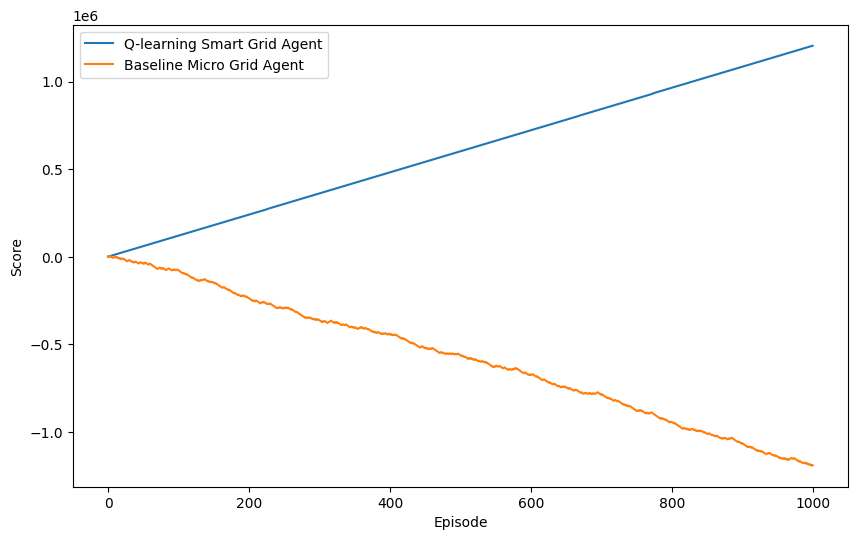

In [306]:
# Initialize variables to track total rewards
q_learning_total_reward = 0
baseline_total_reward = 0
num_episodes = 1000

q_hist, base_hist = [], []

# Run the episodes and accumulate total rewards for both agents
for episode in range(num_episodes):
    # Reset the environment and get initial state
    state = env.reset()

    # Run the Q-learning agent
    for _ in range(100):
        action = q_learning_agent.get_action(state)
        next_state, reward1 = env.step(action)
        q_learning_total_reward += reward1

        action = baseline_agent.get_action(*next_state)
        next_state, reward2 = env.step(action)
        baseline_total_reward += reward2

        state = next_state
    
    base_hist.append(baseline_total_reward)
    q_hist.append(q_learning_total_reward)

# Print the total rewards for both agents
print("Q-learning Agent Total Reward:", q_learning_total_reward)
print("Baseline Agent Total Reward:", baseline_total_reward)

plt.figure(figsize=(10,6))
plt.plot([i for i in range(num_episodes)], q_hist, label="Q-learning Smart Grid Agent")
plt.plot([i for i in range(num_episodes)], base_hist, label="Baseline Micro Grid Agent")
plt.ylabel("Score")
plt.xlabel("Episode")
plt.legend()
plt.show()